# Exploratory data analysis of DeepDeform

The dataset is from https://github.com/AljazBozic/DeepDeform

## Structure

```
deepdeform
├── train_alignments.json
├── train_masks.json            # Dynamic object annotations for a few frames per sequence
├── train_occlusions.json       # Manually annotated sparse occlusions
├── train_matches.json          # Manually annotated sparse matches
├── train_selfsupervised.json   # Densely aligned optical and scene flow images using self-supervision (DynamicFusion pipeline) for a few sequences
├── train
│   ├── seq000                  # <sequence_id>
│   │   ├── color               # color images for every frame (`%06d.jpg`)
│   │   ├── depth               # depth images for every frame (`%06d.png`)
│   │   ├── intrinsics.txt      # 4x4 intrinsics matrix
│   │   ├── mask                # mask images for a few frames (`%06d.png`)
│   │   ├── optical_flow        # optical flow images for a few frame pairs (`<object_id>_<source_id>_<target_id>.oflow`)
│   │   └── scene_flow          # scene flow images for a few frame pairs (`<object_id>_<source_id>_<target_id>.sflow`)
...
│   └── seq339
│       ├── color
│       ├── depth
│       └── intrinsics.txt
│       ├── mask
│       ├── optical_flow
│       └── scene_flow
├── val
├── val_selfsupervised.json     
├── val_occlusions.json
├── val_matches.json
├── val_masks.json
├── val_alignments.json
├── test
│   ├── seq000
│   │   ├── color
│   │   ├── depth
│   │   └── intrinsics.txt
│   ├── seq001
│   │   ├── color
│   │   ├── depth
│   │   └── intrinsics.txt
...
    └── seq029
        ├── color
        ├── depth
        └── intrinsics.txt
```

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
import cv2
import imageio 

from pathlib import Path
from itertools import islice

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

base_path = "/mnt/raid/kirwul/deepdeform"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Helper function

space =  '    '
branch = '│   '
tee =    '├── '
last =   '└── '

def tree(dir_path: Path, level: int=-1, limit_to_directories: bool=False,
         length_limit: int=1000):
    """Given a directory Path object print a visual tree structure.
    From: https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python
    """
    dir_path = Path(dir_path) # accept string coerceable to Path
    files = 0
    directories = 0
    def inner(dir_path: Path, prefix: str='', level=-1):
        nonlocal files, directories
        if not level: 
            return # 0, stop iterating
        if limit_to_directories:
            contents = [d for d in dir_path.iterdir() if d.is_dir()]
        else: 
            contents = list(dir_path.iterdir())
        pointers = [tee] * (len(contents) - 1) + [last]
        for pointer, path in zip(pointers, contents):
            if path.is_dir():
                yield prefix + pointer + path.name
                directories += 1
                extension = branch if pointer == tee else space 
                yield from inner(path, prefix=prefix+extension, level=level-1)
            elif not limit_to_directories:
                yield prefix + pointer + path.name
                files += 1
    print(dir_path.name)
    iterator = inner(dir_path, level=level)
    for line in islice(iterator, length_limit):
        print(line)
    if next(iterator, None):
        print(f'... length_limit, {length_limit}, reached, counted:')
    print(f'\n{directories} directories' + (f', {files} files' if files else ''))

# The dataset file structure
# tree(Path(base_path), level=3)

In [20]:
img_p = base_path + "/train/seq120/"

for i in range(100, 150, 5):
    print(f"000{i}:")
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(plt.imread(img_p + f"color/000{i}.jpg"))
    im = ax[1].imshow(plt.imread(img_p + f"depth/000{i}.png"))
    cax = fig.add_axes([0.95, 0.3, 0.05, 0.4])
    fig.colorbar(im, cax=cax, orientation='vertical')
    plt.show()

clear_output()      # Remove this

In [40]:
d_img = imageio.imread(img_p + "depth/000000.png")
print("Depth shape:", d_img.shape)
rgb_img = imageio.imread(img_p + "/color/000000.jpg")
print("RGB shape:", rgb_img.shape)
print("D-NeRF RGBA shape:", imageio.imread("./data/lego/train/r_0.png").shape)


Depth shape: (480, 640)
RGB shape: (480, 640, 3)
D-NeRF RGBA shape: (800, 800, 4)


Takeaways: 
- We do not need to convert our data to RGB! `.png` is RGBA and `.jpg` is RGB.
- The shape of `.png` is `(W,H)` and the shape of `.jpg` is `(H,W)`.

Resized shape:  (240, 320, 3)


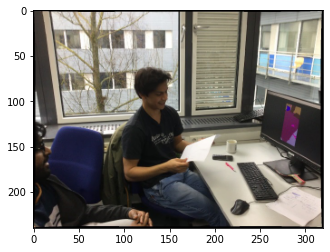

In [42]:
#rgb_img = imageio.imread("./data/lego/train/r_0.png")

H, W, _ = rgb_img.shape
resized_img = cv2.resize(rgb_img, (W//2, H//2), interpolation=cv2.INTER_AREA)
print("Resized shape: ", resized_img.shape)
plt.imshow(resized_img)

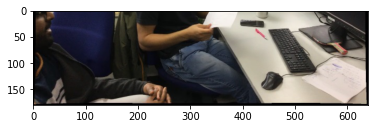

In [39]:
plt.imshow(rgb_img[300:])

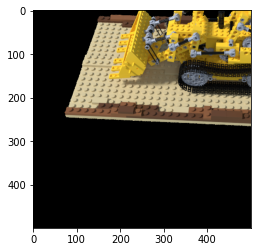

In [38]:
plt.imshow(imageio.imread("./data/lego/train/r_0.png")[300:, :500, :3])